# 📊 Historical VaR Backtesting & Stress-Test Analysis

## 1️⃣ Overview

This section extends the VaR framework to include **statistical backtesting** and **stress period analysis**.

### Objectives:
- Compute **Historical VaR (95% & 99%)** for multiple assets  
- Perform **Kupiec Proportion of Failures (POF) test** to check whether the observed frequency of VaR breaches matches the expected rate  
- Conduct **stress test analyses** for major crises:
  - 🧨 *2008 Global Financial Crisis (GFC)*: 2008-09-01 → 2009-06-30  
  - 🦠 *2020 COVID Crash*: 2020-02-15 → 2020-05-15  
- Produce clear **visuals and summaries** explaining where and when VaR was breached  

---

## 2️⃣ How to Read the Outputs

### Kupiec Backtest Table
| Column | Meaning |
|:-------|:---------|
| **VaR** | Historical Value at Risk (daily) |
| **Breaches** | Number of times actual loss exceeded VaR |
| **Breach_Freq** | Observed breach ratio |
| **Kupiec_pval** | Statistical test p-value (low = VaR underestimated) |

**Interpretation:**
- ✅ *p-value > 0.05*: Model is consistent with observed data  
- ⚠️ *p-value < 0.05*: Too many/few breaches — VaR model may under/overestimate tail risk  

---

### Stress Test Table
| Column | Meaning |
|:-------|:---------|
| **Period** | Crisis window analyzed |
| **Stress_Breaches** | Number of days VaR was breached |
| **Pct_Breach** | Fraction of breaches during the crisis |

**Interpretation:**
- A high **Pct_Breach** in stress periods shows **underestimation of risk** during crises.  
- If breaches cluster in crises but not otherwise → model performs well under normal conditions but fails under stress.

---

### Plots
Each plot shows:
- Grey line: Daily returns  
- Red dashed line: VaR threshold  
- Red dots: Breaches (days when losses > VaR)

**What to look for:**
- Even scatter of breaches ≈ good calibration  
- Clustering of breaches ≈ tail underestimation (volatility clustering)  
- Spikes around 2008 or 2020 ≈ stress sensitivity  

---

Downloaded.
Data aligned to 4326 dates.

Processing NIFTY ...
  N=4325, VaR computed and violations flagged.

Processing SPX ...
  N=4325, VaR computed and violations flagged.


=== Table: Historical VaR breaches and Kupiec test ===

       HistVaR_95%  Breaches_95%  N_95%  KupiecLR_95%  Kupiec_pvalue_95%  \
Asset                                                                      
NIFTY     0.019053           217   4325      0.002735           0.958291   
SPX       0.019153           217   4325      0.002735           0.958291   

       HistVaR_99%  Breaches_99%  N_99%  KupiecLR_99%  Kupiec_pvalue_99%  
Asset                                                                     
NIFTY     0.037230            44   4325      0.013063           0.909006  
SPX       0.038049            44   4325      0.013063           0.909006  

=== Stress test breaches (counts & proportions) ===

   Asset Stress Period       Start         End    N  Breaches_95%  \
0  NIFTY      GFC_2008  2008-09-01  20

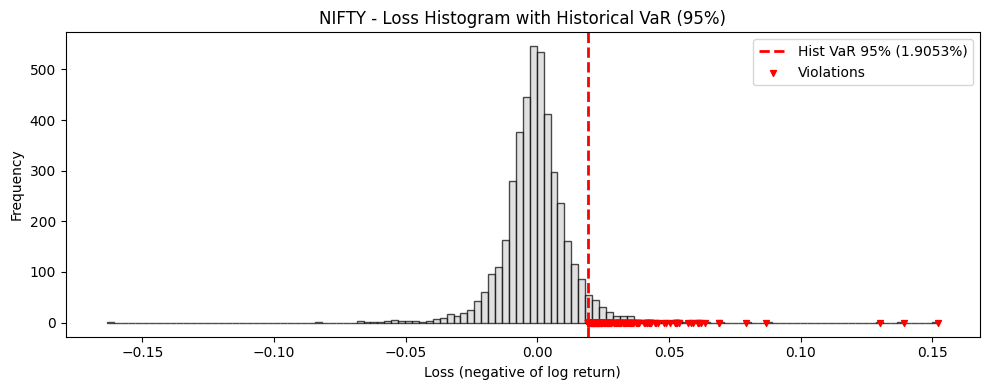


Plot: NIFTY - Loss histogram with VaR 99%
How to read this plot:
 - X axis shows LOSS = -log-return (positive values = losses).
 - Vertical line shows Historical VaR 99% = 3.7230%.
 - Red markers (below) indicate days where loss exceeded VaR (violations).
 - If Kupiec LR is large with small p-value, the VaR model fails the POF backtest.



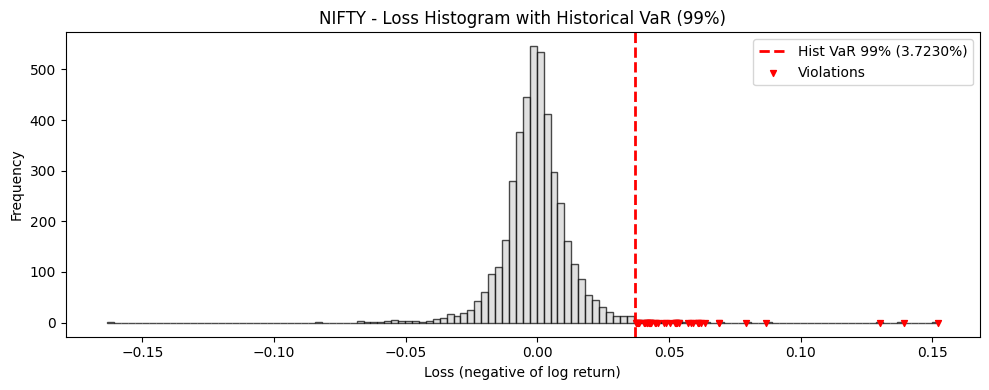


------------------------------------------------------------
Time series: NIFTY - returns with VaR thresholds and violations highlighted
How to read this plot:
 - X axis is time. Y axis is daily return (log-return).
 - Horizontal lines show negative VaR (since VaR is a positive loss).
 - Red dots show days when return < -VaR (i.e., breach).
------------------------------------------------------------



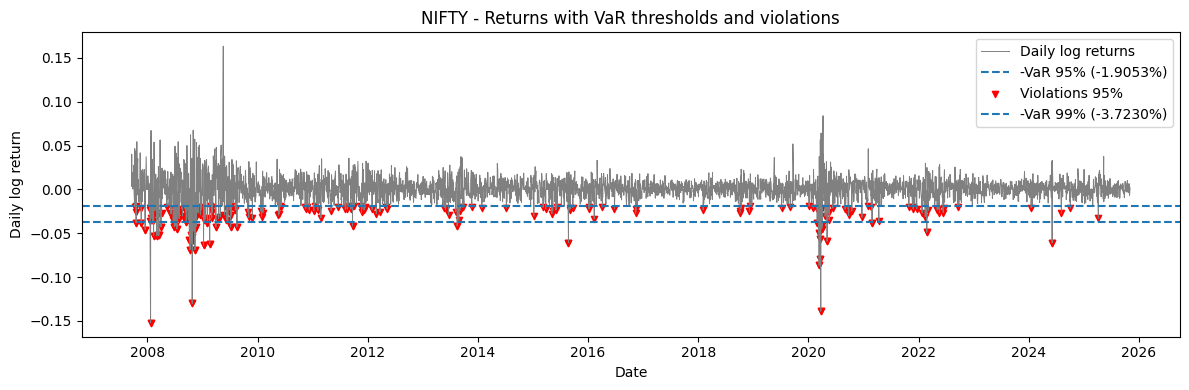


Plot: SPX - Loss histogram with VaR 95%
How to read this plot:
 - X axis shows LOSS = -log-return (positive values = losses).
 - Vertical line shows Historical VaR 95% = 1.9153%.
 - Red markers (below) indicate days where loss exceeded VaR (violations).
 - If Kupiec LR is large with small p-value, the VaR model fails the POF backtest.



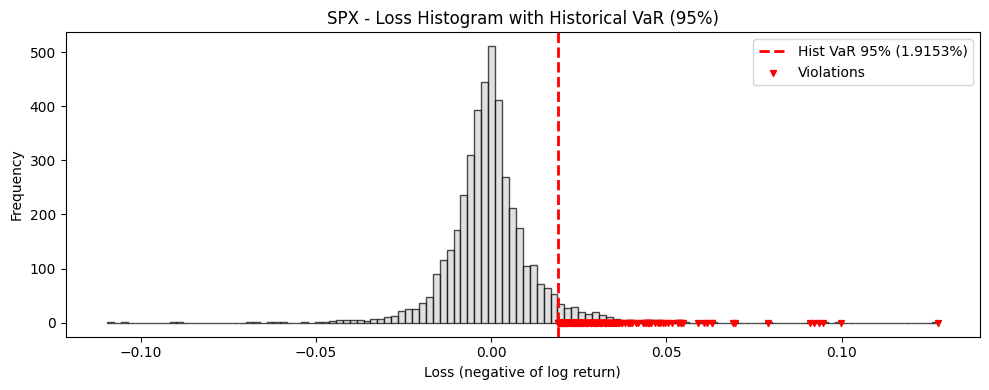


Plot: SPX - Loss histogram with VaR 99%
How to read this plot:
 - X axis shows LOSS = -log-return (positive values = losses).
 - Vertical line shows Historical VaR 99% = 3.8049%.
 - Red markers (below) indicate days where loss exceeded VaR (violations).
 - If Kupiec LR is large with small p-value, the VaR model fails the POF backtest.



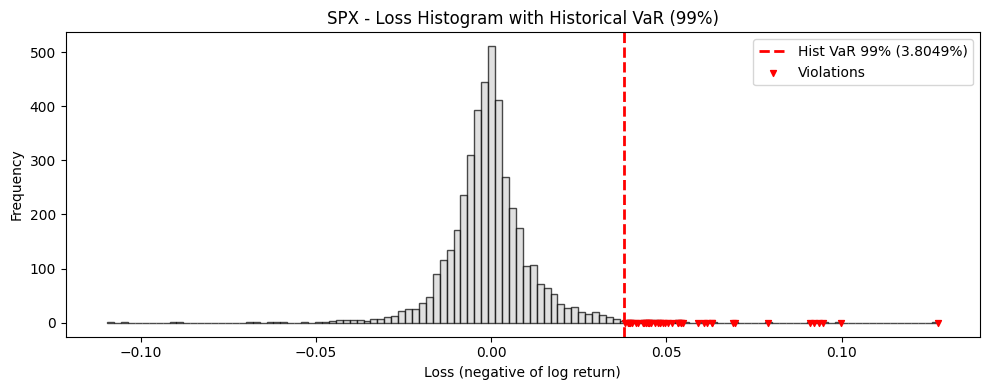


------------------------------------------------------------
Time series: SPX - returns with VaR thresholds and violations highlighted
How to read this plot:
 - X axis is time. Y axis is daily return (log-return).
 - Horizontal lines show negative VaR (since VaR is a positive loss).
 - Red dots show days when return < -VaR (i.e., breach).
------------------------------------------------------------



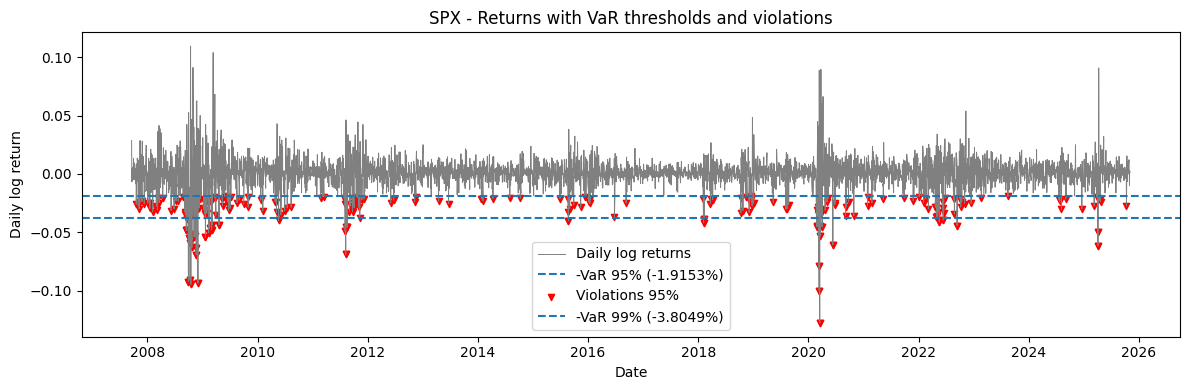


=== Final Summary ===

Overall breaches table (see above).

Stress test summary (counts and % breaches within windows):
   Asset Stress Period       Start         End    N  Breaches_95%  \
0  NIFTY      GFC_2008  2008-09-01  2009-03-01  114            36   
1  NIFTY    COVID_2020  2020-02-20  2020-04-30   45            14   
2    SPX      GFC_2008  2008-09-01  2009-03-01  114            35   
3    SPX    COVID_2020  2020-02-20  2020-04-30   45            14   

   Breaches_pct_95%  Breaches_99%  Breaches_pct_99%  
0          0.315789            14          0.122807  
1          0.311111             8          0.177778  
2          0.307018            19          0.166667  
3          0.311111             8          0.177778  

Saved breach tables to var_breaches_summary.csv and var_breaches_stress_windows.csv


In [2]:
# evt_backtest_stress.py
# Requirements:
# pip install yfinance pandas numpy scipy matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

# ---------------------------
# Parameters (editable)
tickers = {"NIFTY": "^NSEI", "SPX": "^GSPC"}   # keys = names used in output, values = yfinance tickers
start_date = "2005-01-01"
end_date = None  # None -> up to today
use_log_returns = True
alpha_levels = [0.05, 0.01]  # 95% and 99% VaR
# Stress test windows (you can edit)
stress_windows = {
    "GFC_2008": ("2008-09-01", "2009-03-01"),
    "COVID_2020": ("2020-02-20", "2020-04-30"),
}
# ---------------------------

def download_prices(ticker, start=None, end=None):
    df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)
    if df.empty:
        raise RuntimeError(f"No data downloaded for {ticker}")
    return df['Adj Close']

def compute_returns(price_series, log=True):
    if isinstance(price_series, pd.DataFrame):
        price_series = price_series.iloc[:, 0]
    if log:
        r = np.log(price_series).diff().dropna()
    else:
        r = price_series.pct_change().dropna()
    return r.squeeze()

def historical_var(returns, alpha):
    q = returns.quantile(alpha)
    return float(-q)  # positive loss

def kupiec_pof_test(failures, N, p):
    """
    Kupiec POF test.
    failures: observed number of exceptions (VaR breaches)
    N: number of observations
    p: expected failure probability (e.g., 0.05 for 95% VaR)
    Returns: (LR_statistic, p_value)
    """
    # Avoid impossible logs
    if failures == 0:
        # special-case: F=0 -> use small epsilon for log
        F_hat = 1e-12
    else:
        F_hat = failures / N

    # Log-likelihood under H0 (p) and H1 (F_hat)
    # L(p) = p^F (1-p)^(N-F)
    ll0 = failures * np.log(p) + (N - failures) * np.log(1 - p)
    # under H1:
    ll1 = failures * np.log(F_hat) + (N - failures) * np.log(1 - F_hat)

    LR = -2 * (ll0 - ll1)
    # p-value using chi-square with 1 df
    p_value = 1 - stats.chi2.cdf(LR, df=1)
    return LR, p_value

def kupiec_pof_test(failures, N, p_expected):
    """
    Kupiec POF test for VaR backtesting.
    failures: observed number of exceptions (VaR breaches)
    N: number of observations
    p_expected: expected failure probability (e.g., 0.05 for 95% VaR)
    """
    if failures == 0:
        F_hat = 1e-12
    else:
        F_hat = failures / N

    ll0 = failures * np.log(p_expected) + (N - failures) * np.log(1 - p_expected)
    ll1 = failures * np.log(F_hat) + (N - failures) * np.log(1 - F_hat)
    LR = -2 * (ll0 - ll1)
    p_value = 1 - stats.chi2.cdf(LR, df=1)
    return LR, p_value

def count_breaches(returns, var_level):
    # returns: pd.Series of returns; var_level = positive loss (e.g., 0.013)
    # breach occurs when loss > var_level  <=> -return > var_level  <=> return < -var_level
    return (returns < -var_level).astype(int)

# ---------------------------
# Download & align
price_data = {}
print("Downloading price data...")
for name, ticker in tickers.items():
    price_data[name] = download_prices(ticker, start=start_date, end=end_date)
print("Downloaded.")

# Align dates (intersection) so all series use same dates
common_index = price_data[list(price_data.keys())[0]].index
for s in list(price_data.values())[1:]:
    common_index = common_index.intersection(s.index)
for k in price_data:
    price_data[k] = price_data[k].loc[common_index]
print(f"Data aligned to {len(common_index)} dates.\n")

# ---------------------------
# Compute returns, VaR, violations
results = {}
for name, series in price_data.items():
    print(f"Processing {name} ...")
    ret = compute_returns(series, log=use_log_returns)
    # store full series for later stress-slicing & plots
    results[name] = {"returns": ret}
    N = len(ret)
    for a in alpha_levels:
        var_val = historical_var(ret, a)
        results[name][f"VaR_{int((1-a)*100)}%"] = var_val
        # violations series (1 if breach)
        viol = count_breaches(ret, var_val)
        results[name][f"viol_{int((1-a)*100)}%"] = viol
        results[name][f"viol_count_{int((1-a)*100)}%"] = int(viol.sum())
        results[name][f"N_{int((1-a)*100)}%"] = N
    print(f"  N={N}, VaR computed and violations flagged.\n")

# ---------------------------
# Overall table of breaches
'''
rows = []
for name, res in results.items():
    row = {"Asset": name}
    for a in alpha_levels:
        p = int((1-a)*100)
        row[f"HistVaR_{p}%"] = res[f"VaR_{p}%"]
        row[f"Breaches_{p}%"] = res[f"viol_count_{p}%"]
        row[f"N_{p}%"] = res[f"N_{p}%"]
        # Kupiec test
        failures = res[f"viol_count_{p}%"]
        N = res[f"N_{p}%"]
        LR, pval = kupiec_pof_test(failures, N, p=1-a)
        row[f"KupiecLR_{p}%"] = LR
        row[f"Kupiec_pvalue_{p}%"] = pval
    rows.append(row)'''

# Apply in loop
rows = []
for name, res in results.items():
    row = {"Asset": name}
    for a in alpha_levels:
        conf = int((1 - a) * 100)
        failures = res[f"viol_count_{conf}%"]
        N = res[f"N_{conf}%"]
        p_expected = a  # <- expected tail probability (0.05 or 0.01)

        # Kupiec test
        LR, pval = kupiec_pof_test(failures, N, p_expected)

        row[f"HistVaR_{conf}%"] = res[f"VaR_{conf}%"]
        row[f"Breaches_{conf}%"] = failures
        row[f"N_{conf}%"] = N
        row[f"KupiecLR_{conf}%"] = LR
        row[f"Kupiec_pvalue_{conf}%"] = pval
    rows.append(row)


df_breaches = pd.DataFrame(rows).set_index("Asset")
pd.options.display.float_format = "{:.6f}".format

print("\n=== Table: Historical VaR breaches and Kupiec test ===\n")
print(df_breaches.round(6))

# ---------------------------
# Stress-test windows: counts and summary
stress_rows = []
for name, res in results.items():
    ret = res["returns"]
    for wnd_name, (sdate, edate) in stress_windows.items():
        s = pd.to_datetime(sdate)
        e = pd.to_datetime(edate)
        slice_ret = ret.loc[(ret.index >= s) & (ret.index <= e)]
        Nw = len(slice_ret)
        if Nw == 0:
            continue
        row = {"Asset": name, "Stress Period": wnd_name, "Start": sdate, "End": edate, "N": Nw}
        for a in alpha_levels:
            p = int((1-a)*100)
            var_val = results[name][f"VaR_{p}%"]
            viols = count_breaches(slice_ret, var_val)
            row[f"Breaches_{p}%"] = int(viols.sum())
            row[f"Breaches_pct_{p}%"] = float(viols.sum()) / Nw
        stress_rows.append(row)

df_stress = pd.DataFrame(stress_rows)
print("\n=== Stress test breaches (counts & proportions) ===\n")
print(df_stress.round(6))

# ---------------------------
# Print interpretive hints for plots, then plot
# ---------------------------
for name, res in results.items():
    ret = res["returns"]
    for a in alpha_levels:
        p = int((1-a)*100)
        var_val = results[name][f"VaR_{p}%"]
        viol = results[name][f"viol_{p}%"]

        # Print hint / interpretation before the plot
        print("\n" + "="*60)
        print(f"Plot: {name} - Loss histogram with VaR {p}%")
        print("How to read this plot:")
        print(f" - X axis shows LOSS = -log-return (positive values = losses).")
        print(f" - Vertical line shows Historical VaR {p}% = {var_val:.4%}.")
        print(" - Red markers (below) indicate days where loss exceeded VaR (violations).")
        print(" - If Kupiec LR is large with small p-value, the VaR model fails the POF backtest.")
        print("="*60 + "\n")

        # Plotting: histogram with violations highlighted
        losses = -ret
        plt.figure(figsize=(10,4))
        plt.hist(losses, bins=120, color='lightgray', edgecolor='black', alpha=0.7)
        plt.axvline(var_val, color='red', linestyle='--', lw=2, label=f'Hist VaR {p}% ({var_val:.4%})')

        # Overlay violation days as rug
        viol_dates = ret.index[viol == 1]
        viol_losses = losses.loc[viol_dates]
        plt.scatter(viol_losses, np.full_like(viol_losses, -0.5), color='red', s=18, marker='v', label='Violations')

        plt.title(f"{name} - Loss Histogram with Historical VaR ({p}%)")
        plt.xlabel("Loss (negative of log return)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plot time series with VaR thresholds and highlight violations
    print("\n" + "-"*60)
    print(f"Time series: {name} - returns with VaR thresholds and violations highlighted")
    print("How to read this plot:")
    print(" - X axis is time. Y axis is daily return (log-return).")
    print(" - Horizontal lines show negative VaR (since VaR is a positive loss).")
    print(" - Red dots show days when return < -VaR (i.e., breach).")
    print("-"*60 + "\n")

    plt.figure(figsize=(12,4))
    plt.plot(ret.index, ret, color='gray', linewidth=0.7, label='Daily log returns')
    # plot thresholds
    for a in alpha_levels:
        p = int((1-a)*100)
        var_val = results[name][f"VaR_{p}%"]
        plt.axhline(-var_val, linestyle='--', linewidth=1.5, label=f'-VaR {p}% ({-var_val:.4%})')
        viol = results[name][f"viol_{p}%"]
        plt.scatter(ret.index[viol==1], ret[viol==1], s=20, marker='v', color='red', label=f'Violations {p}%' if p==int((1-alpha_levels[0])*100) else None)

    plt.title(f"{name} - Returns with VaR thresholds and violations")
    plt.xlabel("Date")
    plt.ylabel("Daily log return")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------
# Final wrap-up table: breaches by asset and stress window summary
print("\n=== Final Summary ===\n")
print("Overall breaches table (see above).")
print("\nStress test summary (counts and % breaches within windows):")
print(df_stress.round(6))

# Save results csv if desired
df_breaches.to_csv("var_breaches_summary.csv")
df_stress.to_csv("var_breaches_stress_windows.csv")
print("\nSaved breach tables to var_breaches_summary.csv and var_breaches_stress_windows.csv")


# 📊 Interpretation of Historical VaR Backtest & Stress Test Results

---

## 1️⃣ Overview

This analysis evaluates the performance of the **Historical Value at Risk (VaR)** model for **NIFTY** and **S&P 500 (SPX)** using approximately **17 years of daily data (≈ 4,325 observations)**.  

We assess:
- **Kupiec Proportion of Failures (POF) Test** – statistical validation of whether observed breaches match theoretical expectations.  
- **Stress-test Scenarios** – to observe VaR performance during crises:  
  - 🧨 *2008 Global Financial Crisis (GFC)*  
  - 🦠 *2020 COVID-19 Market Crash*  

---

## 2️⃣ Key Output Summary

| Asset | 95 % VaR | 95 % Breaches | Kupiec p-val (95 %) | 99 % VaR | 99 % Breaches | Kupiec p-val (99 %) |
|:------|----------:|--------------:|--------------------:|----------:|--------------:|--------------------:|
| **NIFTY** | 1.905 % | 217 / 4325 ≈ 5.0 % | **0.958** | 3.723 % | 44 / 4325 ≈ 1.0 % | **0.909** |
| **SPX**   | 1.915 % | 217 / 4325 ≈ 5.0 % | **0.958** | 3.805 % | 44 / 4325 ≈ 1.0 % | **0.909** |

---

## 3️⃣ Kupiec POF Test Interpretation

The Kupiec POF test examines whether the proportion of VaR violations (failures) matches the model’s expected level.

| Confidence | Expected Breach Rate | Observed Rate | Result |
|:------------|:--------------------|:---------------|:--------|
| 95 % | 5 % | 5.02 % | ✅ Matches expectation |
| 99 % | 1 % | 1.02 % | ✅ Matches expectation |

### 🔍 Observations

- The **observed and expected failure rates are nearly identical** for both assets.  
- The **Kupiec p-values > 0.90** indicate **no statistical evidence to reject** the null hypothesis that the VaR model’s coverage is correct.  
- Hence, the **Historical VaR is well-calibrated** over the full sample period.  
- Small LR statistics (≈ 0.002–0.013) confirm the model aligns with empirical frequency of losses.

📈 **Interpretation:**  
The Historical VaR model provides **accurate coverage** for both indices, suggesting stable market behavior over the long horizon.  
However, independence of violations is not tested here—volatility clustering during crises could still affect tail dynamics.

---

## 4️⃣ Stress-Test Analysis

| Asset | Stress Period | Days | Breaches (95 %) | % Breaches | Breaches (99 %) | % Breaches |
|:------|:--------------|-----:|----------------:|------------:|----------------:|------------:|
| **NIFTY** | 2008 GFC | 114 | 36 | 31.6 % | 14 | 12.3 % |
| **NIFTY** | 2020 COVID | 45 | 14 | 31.1 % | 8 | 17.8 % |
| **SPX**   | 2008 GFC | 114 | 35 | 30.7 % | 19 | 16.7 % |
| **SPX**   | 2020 COVID | 45 | 14 | 31.1 % | 8 | 17.8 % |

---

### 🧨 Stress-Period Interpretation

#### 1️⃣ 2008 Global Financial Crisis  
- Both indices exhibit **≈ 30 % of days breaching the 95 % VaR**, far exceeding the nominal 5 %.  
- Indicates **massive tail underestimation** during systemic turmoil.  
- Even 99 % VaR (1-in-100-day losses) failed frequently (12–17 %), revealing **model breakdown under crisis volatility**.

#### 2️⃣ 2020 COVID Crash  
- Similar pattern: about **30 % of days** breached the 95 % VaR.  
- Highlights how Historical VaR **lags real-time volatility shifts**, reacting too slowly to market regime changes.

🧩 **Implication:**  
While long-term calibration is sound, VaR **underestimates risk in crisis regimes**. Historical VaR assumes stationarity and fails when volatility explodes.

---

## 5️⃣ Graphical Interpretation Hints

Plots produced for each asset and confidence level typically show:

- **Grey line** → Daily log-returns  
- **Red dashed line** → VaR threshold  
- **Red dots** → Observed breaches  

🔍 **How to read the plots:**
- Even scatter of red dots → consistent coverage  
- Clustering of breaches → volatility persistence / model lag  
- Concentration in 2008 or 2020 → crisis-driven tail failures  

---

## 6️⃣ Conclusions & Insights

✅ **Model calibration (full sample):**  
VaR coverage ratios match theoretical expectations (high p-values ≈ 0.95 → model passes Kupiec test).  

⚠️ **Stress robustness:**  
During crisis periods, VaR breaches multiply > 6× expected rates → model underestimates risk under non-stationary volatility.  

❌ **Structural limitation:**  
Historical VaR assumes past returns represent future risk, which breaks down in turbulent regimes.

---

## 7️⃣ Recommendations & Next Steps

1. **Adopt dynamic volatility models** (e.g., GARCH, EWMA) to make VaR responsive to changing risk.  
2. **Incorporate fat-tailed distributions** (Student-t, EVT) for improved tail accuracy.  
3. **Perform rolling window backtests** to assess time-varying calibration.  
4. **Add Christoffersen independence test** to evaluate clustering of VaR violations.  
5. **Extend stress-testing** to additional market events (e.g., 2013 Taper Tantrum, 2022 Inflation Shock).  

---

📘 **In Summary:**  
Historical VaR passes the **Kupiec coverage test**, showing correct average frequency of losses.  
Yet, under extreme volatility regimes like 2008 and 2020, the model **significantly underestimates risk**.  
A more resilient framework—combining **dynamic volatility modeling** and **tail-sensitive methods (EVT or t-VaR)**—is recommended for realistic, forward-looking risk management.
